<a href="https://colab.research.google.com/github/vstrah00/BarAppV2/blob/master/gpu_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycuda

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*in out-of-thread context.*")

GPU Execution Time: 0.0993 seconds


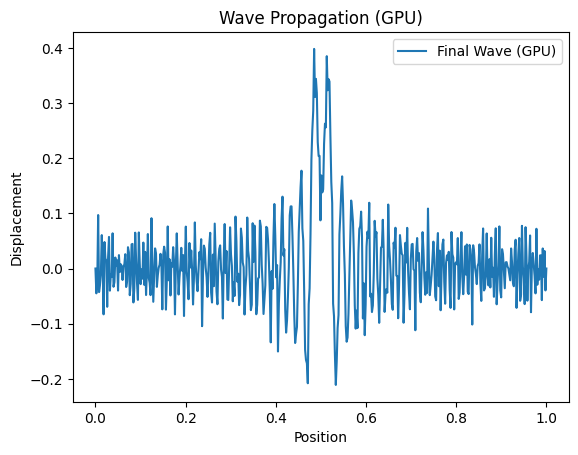

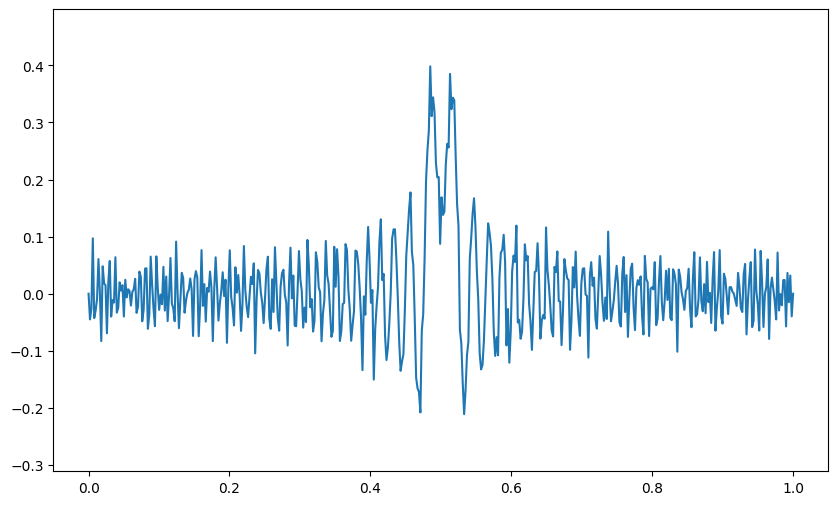

In [ ]:
# GPU: Wave Propagation on GPU using CUDA

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Simulation parameters
L = 1.0       # Length of the string
N = 500       # Number of grid points (adjust for larger grid)
dx = L / N    # Grid spacing
c = 1.0       # Wave speed
dt = 0.001    # Lowered time step to prevent overflow
steps = 2000  # Number of steps in the simulation

# CUDA kernel code
wave_kernel = """
__global__ void update_wave(float *u_prev, float *u_curr, float *u_next, int N, float c, float dt, float dx) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i > 0 && i < N-1) {
        u_next[i] = 2 * u_curr[i] - u_prev[i] + (c * dt / dx) * (c * dt / dx) * (u_curr[i+1] - 2 * u_curr[i] + u_curr[i-1]);
    }
}
"""

# Compile the kernel
mod = SourceModule(wave_kernel)
update_wave = mod.get_function("update_wave")

# Initialize arrays
u_prev = np.zeros(N, dtype=np.float32)
u_curr = np.zeros(N, dtype=np.float32)
u_next = np.zeros(N, dtype=np.float32)

# Initial condition
u_curr[N // 2] = 1.0  # Impulse at the center

# Store wave frames for video
wave_frames = []

# Measure GPU execution time
start_time = time.time()

# Allocate memory on the GPU
u_prev_gpu = cuda.mem_alloc(u_prev.nbytes)
u_curr_gpu = cuda.mem_alloc(u_curr.nbytes)
u_next_gpu = cuda.mem_alloc(u_next.nbytes)

# Copy initial data to GPU
cuda.memcpy_htod(u_prev_gpu, u_prev)
cuda.memcpy_htod(u_curr_gpu, u_curr)
cuda.memcpy_htod(u_next_gpu, u_next)

# Define grid and block sizes
threads_per_block = 32
blocks_per_grid = (N + threads_per_block - 1) // threads_per_block

# Simulation loop
for _ in range(steps):
    # Apply the CUDA kernel to update the wave
    update_wave(u_prev_gpu, u_curr_gpu, u_next_gpu, np.int32(N), np.float32(c), np.float32(dt), np.float32(dx),
                block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))

    # Swap buffers
    u_prev_gpu, u_curr_gpu, u_next_gpu = u_curr_gpu, u_next_gpu, u_prev_gpu

    # Copy the current wave data back to the host (CPU)
    cuda.memcpy_dtoh(u_curr, u_curr_gpu)

    # Store frames for the animation
    wave_frames.append(u_curr.copy())

# Measure end time
end_time = time.time()
gpu_execution_time = end_time - start_time
np.save("gpu_time.npy", np.array(gpu_execution_time))  # Save execution time

# Save wave frames for video
np.save("gpu_wave_frames.npy", wave_frames)

# Print GPU execution time
print(f"GPU Execution Time: {gpu_execution_time:.4f} seconds")

# Plot the final wave result
x = np.linspace(0, L, N)
plt.plot(x, u_curr, label="Final Wave (GPU)")
plt.title("Wave Propagation (GPU)")
plt.xlabel("Position")
plt.ylabel("Displacement")
plt.legend()
plt.show()

# Create an animation of the wave propagation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, np.zeros(N), label="Wave")
ax.set_ylim(min(u_curr) - 0.1, max(u_curr) + 0.1)  # Set initial y-limits

def update_frame(frame):
    line.set_ydata(frame)
    ax.set_ylim(min(frame) - 0.1, max(frame) + 0.1)  # Update y-limits for each frame
    return line,

# Create animation
ani = animation.FuncAnimation(fig, update_frame, wave_frames, blit=True, interval=50)

# Save animation
try:
    ani.save('gpu_wave_propagation.mp4', writer='ffmpeg', fps=30)
except ValueError as e:
    print(f"Error saving video: {e}")
